In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import statistics
#from scipy import special
import scipy.optimize as so

In [7]:
from functions_Finite_Difference import *   #library containing all the functions I created to implement the finite difference scheme

## 4 finite difference schemes were implemented (functions in the py library) and then compared to the analytical solution with the quantifying indicator RMSE

In [21]:
#PARAMETERS

#spatial domain (cm)
dx=1 
limx=100
xx=np.arange(0,limx,dx)

#time domain  (h)
limt=100
dt=1
tt=np.arange(0,limt,dt)

#variables 
s=5  #standard dev   gaussian
mu=50   #gaussian mean 
K=0.4 #thermal conductivity 

### ANALYTICAL SOLUTION
$$ u(x,t)= \frac{1}{2\sqrt{\pi K t}} \int_0 ^L   f(y,t_0) \exp {-\left( \frac{(x-y)^2}{4Kt}\right)} dy
$$

C:\Users\brune\anaconda3\envs\sigtest\lib\site-packages\scipy\stats\_distn_infrastructure.py:2085: RuntimeWarning: divide by zero encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
C:\Users\brune\anaconda3\envs\sigtest\lib\site-packages\scipy\stats\_distn_infrastructure.py:2085: RuntimeWarning: invalid value encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


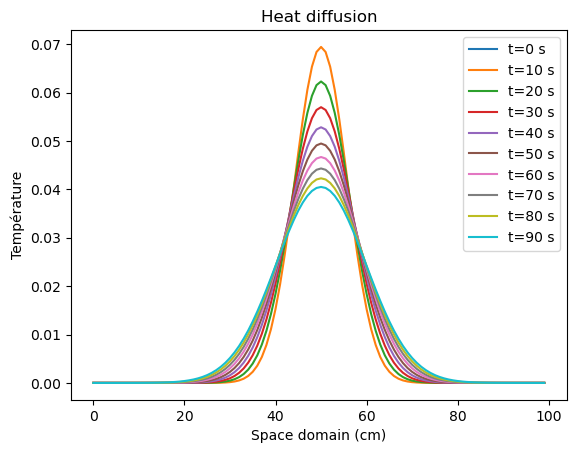

In [26]:
Ta=analytical_solution(dx,limx,dt,limt,K,plot=1)



## Euler forward explicit scheme
$$u^{n+1}_j =  u^{n}_j+ \frac{K dt}{dx^2} \left(u^{n}_{j-1}+u^{n}_{j+1} -2u^{n}_{j} \right)$$

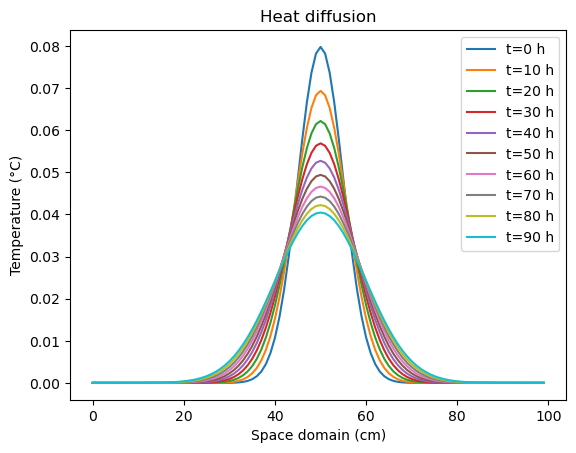

In [27]:
Tf=euler_f(dx,limx,dt,limt,K ,plot=1)

#STABILITY ANALYSIS  K dt /dx²   < 0.5    

## Euler backward implicit scheme
$$ u^{n+1}_j =  u^{n}_j+ \frac{K dt}{dx^2} \left(u^{n+1}_{j-1}+u^{n+1}_{j+1} -2u^{n+1}_{j} \right) $$

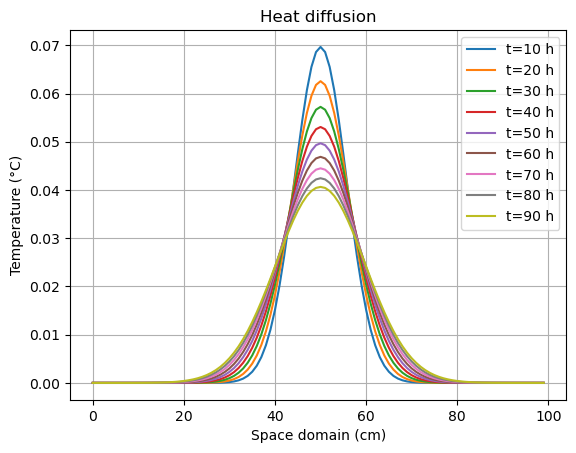

In [28]:

Tb=euler_b(dx,limx,dt,limt,K,plot=1)


## Durfort- Frankel scheme 3 levels of time     using euler forward to have initial condition T(t=1,x)

$$\frac{u^{n+1}_j-u^{n-1}_j}{2 \Delta t} = \frac{\sigma}{\Delta x^2}\left( u^{n}_{j-1}-u^{n+1}_{j}-u^{n-1}_{j} +u^{n}_{j+1} \right)  $$

$$ u^{n+1}_j-u^{n-1}_j =\frac{\sigma 2 \Delta t}{\Delta x^2}\left( u^{n}_{j-1}-u^{n+1}_{j}-u^{n-1}_{j} +u^{n}_{j+1} \right) $$

$$ u^{n+1}_j  = \frac{1-A}{1+A} u^{n-1}_j+ \frac{A}{1+A} \left(u^{n}_{j-1}+u^{n}_{j+1} \right)$$

with $A=\frac{\sigma 2 \Delta t}{\Delta x^2}$

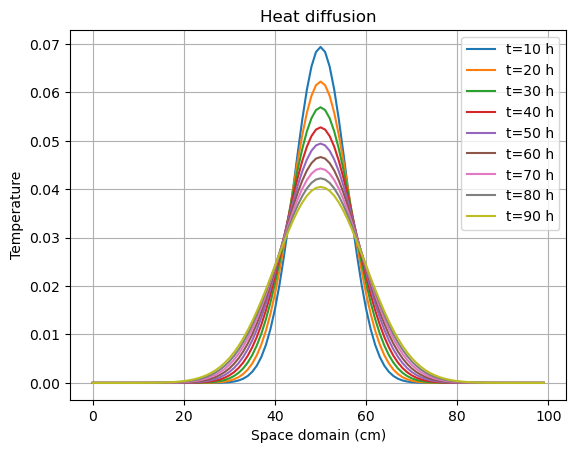

In [29]:

Td=Dufort_Frankel(dx,limx,dt,limt,Tf,K,plot=1)

## Crank Nicolson scheme, theta scheme =0.5, implicit
resolution of a linear system with the help of a cost function

$$ \frac{u^{n+1}_j-u^{n}_j}{\Delta t}= \theta \frac{K }{\Delta x^2} \left( u^{n+1}_{j-1}-2u^{n+1}_{j}+u^{n+1}_{j+1}  \right) +(1-\theta)\frac{K }{\Delta x^2}   \left( u^{n}_{j-1}-2 u^{n}_{j}+u^{n}_{j+1}\right) $$

  $$  -\theta A u^{n+1}_{j-1}+(1+2\theta A)u^{n+1}_j -\theta A u^{n+1}_{j+1} = (1-\theta)A u^{n}_{j-1} + (1-2 A+2\theta A)  u^{n}_{j} +(1-\theta)A u^{n}_{j+1}$$

with $A=\frac{K \Delta t}{\Delta x^2}$


In [30]:
def LeftOp(X,dx,dt,K): #left part of equation
    theta =0.5
    A = K*dt*theta/(dx**2)
    thA = theta*A
    Z = -thA*np.roll(X,1) -thA*np.roll(X,-1) + (1+2*thA)*X
    return Z

def RightOp(X,dx,dt,K):#right part of equation 
    theta =0.5
    A = K*dt*theta/(dx**2)
    thA = theta*A
    Z = (A-thA)*np.roll(X,1) + (A-thA)*np.roll(X,-1) + (1-2*A+2*thA)*X
    return Z

def CostFunc_CN(X, b,dx,dt,K): #cost function
    return 0.5*np.dot(X,LeftOp(X,dx,dt,K)) - np.dot(X,b)

def CostGrad_CN(X, b,dx,dt,K): # cost gradient 
    return LeftOp(X,dx,dt,K) - b



def Crank_Nicolson(dx,limx,dt,limt,K,plot=0):
#______________________________________________________     
   #space domain (cm)
    xx=np.arange(0,limx,dx)

    # time domain  (hours)
    tt=np.arange(0,limt,dt)

#variables 
    s=5  #standard dev   gaussian
    mu=50   #gaussian mean    
#____________________,_______________________________________    
    Tc=np.zeros((len(tt),len(xx)))
    Tc[0,:]=gauss(xx, mu, s) #Initial conditions
    #Boundary Conditions 
    Tc[:,0]=np.zeros(len(tt))
    Tc[:,-1]=np.zeros(len(tt))
    
    theta =0.5
    A = K*dt*theta/(dx**2)
    thA = theta*A

    for i in range(1,len(tt)):
        b = RightOp(Tc[i-1,:],dx,dt,K)
        Xopt = Tc[i-1,:]
#minimization of the Cost function to find the best fit     
        res = so.minimize(CostFunc_CN, Xopt, args=(b,dx,dt,K),
                          method='L-BFGS-B',jac=CostGrad_CN,
                          options={'maxiter': 20})
        Tc[i,:] = res['x']
        
        if plot==1:
            if i%10==0:
                plt.plot(xx,Tc[i,:],label='t='+str(i)+' h')
                plt.legend()
                plt.xlabel('Space domain (cm)')
                plt.ylabel('Temperature (°C)')
                plt.grid()
                plt.title('Heat diffusion')
    return Tc


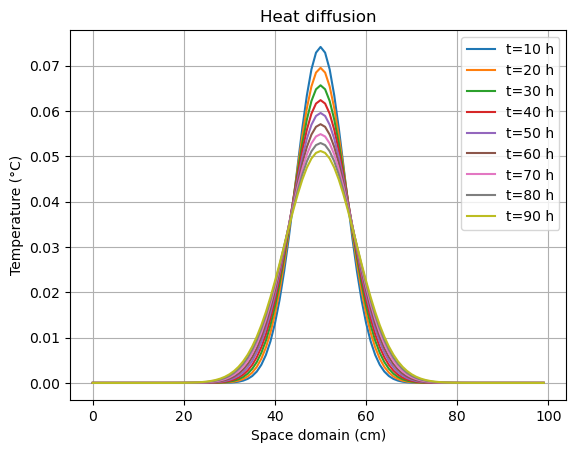

In [31]:
Tc=Crank_Nicolson(dx,limx,dt,limt,K,plot=1)

In [92]:
Tc=Crank_Nicolson(dx,limx,dt,limt,K)
Ta=analytical_solution(dx,limx,dt,limt,K)
Tf=euler_f(dx,limx,dt,limt,K)
Tb=euler_b(dx,limx,dt,limt,K)
Td=Dufort_Frankel(dx,limx,dt,limt,Tf,K)


C:\Users\brune\anaconda3\envs\sigtest\lib\site-packages\scipy\stats\_distn_infrastructure.py:2085: RuntimeWarning: divide by zero encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
C:\Users\brune\anaconda3\envs\sigtest\lib\site-packages\scipy\stats\_distn_infrastructure.py:2085: RuntimeWarning: invalid value encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


Root Mean Square error between finite difference results and analytical solution of the heat equation

$RMSE=\sqrt{\frac{\sum_{i=1}^n (y_i-p_i)^2}{n}}$

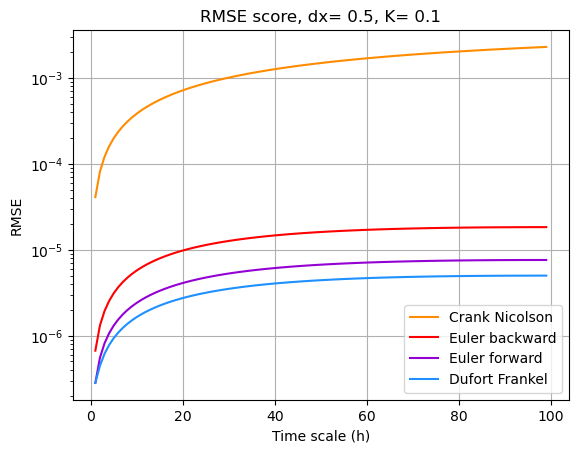

In [93]:
RMSEt=np.zeros(len(tt))
RMSEd=np.zeros(len(tt))
RMSEc=np.zeros(len(tt))
RMSEb=np.zeros(len(tt))
for i in range (0,len(tt)):
    RMSEt[i]=RMSE(Ta[i,:],Tf[i,:])
    RMSEd[i]=RMSE(Ta[i,:],Td[i,:])
    RMSEb[i]=RMSE(Ta[i,:],Tb[i,:])
    RMSEc[i]=RMSE(Ta[i,:],Tc[i,:])
    
plt.semilogy(tt,RMSEc,label='Crank Nicolson',color='darkorange')
plt.plot(tt,RMSEb,label='Euler backward',color='red')
plt.plot(tt,RMSEt,label='Euler forward',color='darkviolet')
plt.plot(tt,RMSEd,label='Dufort Frankel',color='dodgerblue')


plt.legend()
plt.xlabel('Time scale (h)')
plt.ylabel('RMSE')
plt.title('RMSE score, dx= '+str(dx)+', K= '+str(K))
plt.grid()
#plt.savefig('RMSEdx1,K0.4.pdf',dpi=300)

In [4]:

#PARAMETERS
#________________________________________________________
dxlist=[0.2,0.4,0.8,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6,6.5,7,7.5,8,8.8,9,9.5,10,10.5,11,11.5,12]#dxlist=np.arange(0.2,15,0.2)
dxlistbis=[0.8,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6,6.5,7,7.5,8,8.8,9,9.5,10,10.5,11,11.5,12] #for euler forward to respect stability conditions

dX=0.1

dt=1
limt=100
tt=np.arange(0,limt,dt)#domaine temporel  (en h)
    
s=5  #standard dev   gaussian
mu=50   #moyenne gaussienne 
K=0.1  

RMSEbb=np.zeros(len(dxlist))  #Euler backward
RMSEff=np.zeros(len(dxlist))  #Euler forward
RMSEcc=np.zeros(len(dxlist))  #Crank Nicolson
RMSEdd=np.zeros(len(dxlist))  #Dufort Frankel

for l in range(len(dxlist)):
    dx=dxlist[l]
    
    Ta=analytical_solution(dx,limx,dt,limt,K)
    
      
    Tb=euler_b(dx,limx,dt,limt,K)
    RMSEb=np.zeros(len(tt))
    
    Td=Dufort_Frankel(dx,limx,dt,limt,Tb,K)
    RMSEd=np.zeros(len(tt))
    
    Tc=Crank_Nicolson(dx,limx,dt,limt,K)
    RMSEc=np.zeros(len(tt))
    
    Tf=euler_f(dx,limx,dt,limt,K)
    RMSEf=np.zeros(len(tt))
    
    for i in range (0,len(tt)):
        RMSEd[i]=RMSE(Ta[i,:],Td[i,:])
        RMSEb[i]=RMSE(Ta[i,:],Tb[i,:])
        RMSEc[i]=RMSE(Ta[i,:],Tc[i,:])
        RMSEf[i]=RMSE(Ta[i,:],Tf[i,:])
    
    RMSEbb[l]=np.nansum(RMSEb)
    RMSEdd[l]=np.nansum(RMSEd)
    RMSEcc[l]=np.nansum(RMSEc)
    if dx<0.5: #stability condition
        RMSEff[l]=float('nan')
    else:
        RMSEff[l]=np.nansum(RMSEf)

C:\Users\brune\anaconda3\envs\sigtest\lib\site-packages\scipy\stats\_distn_infrastructure.py:2085: RuntimeWarning: divide by zero encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
C:\Users\brune\anaconda3\envs\sigtest\lib\site-packages\scipy\stats\_distn_infrastructure.py:2085: RuntimeWarning: invalid value encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


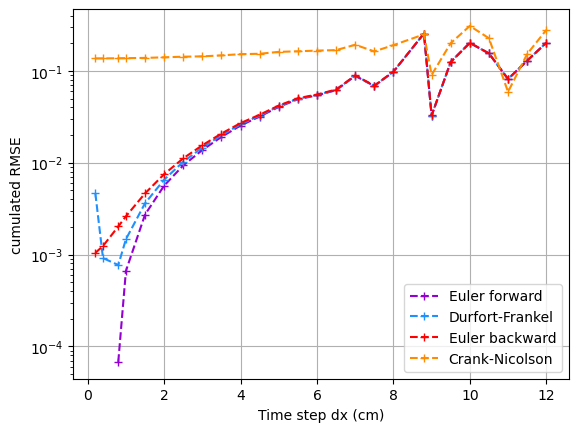

In [23]:


plt.semilogy(dxlist,RMSEff,color='darkviolet',linestyle='--',marker='+',label='Euler forward')
plt.plot(dxlist,RMSEdd,color='dodgerblue',linestyle='--',marker='+',label='Durfort-Frankel')
plt.plot(dxlist,RMSEbb,color='r',linestyle='--',marker='+',label='Euler backward')
plt.plot(dxlist,RMSEcc,color='darkorange',linestyle='--',marker='+',label='Crank-Nicolson')
    
plt.xlabel('Time step dx (cm)')
plt.ylabel('cumulated RMSE')
plt.legend()
plt.grid()


            
plt.savefig('dxRMSE.png',dpi=300)